In [1]:
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体（显示中文）

import torch
from sklearn.metrics import mean_squared_error,mean_absolute_error
from torch.utils.data import DataLoader

from importlib import reload
import utils
reload(utils)
from utils import seed_everything,get_data,TimeSeriesDataSet,CoronaVirusPredictor
seed_everything(2023)
# https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/05.time-series-forecasting-covid-19.ipynb

In [2]:
def train_model(args, model, train_dataloader, valid_dataloader=None):
    loss_fn = torch.nn.MSELoss(reduction='mean').to(args.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader) // 30, gamma=0.99)
    train_hist = []
    valid_hist = []
    best_loss = np.inf
    num = 0

    for t in range(args.num_epochs):
        t += 1
        model.train()
        train_loss = []
        pbar = tqdm(enumerate(train_dataloader,start=1))
        for idx,(train_data, train_labels) in pbar:
            model.reset_hidden_state()
            y_pred = model(train_data.to(args.device))
            loss = loss_fn(y_pred.float(), train_labels.to(args.device))
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            pbar.set_description(f'\t[Train] Iter: {idx}/{len(train_dataloader)} loss: {loss.item():.10f}')

        train_loss = np.array(train_loss).mean()
        train_hist.append(train_loss)
        if valid_dataloader is not None:
            model.eval()
            pbar = tqdm(enumerate(valid_dataloader,start=1))
            with torch.no_grad():
                valid_loss = []
                for idx,(valid_data, valid_labels) in pbar:
                    y_valid_pred = model(valid_data.to(args.device))
                    val_loss = loss_fn(y_valid_pred.float(),valid_labels.to(args.device))
                    valid_loss.append(val_loss.item())
                    pbar.set_description(f'\t[Valid] Iter: {idx}/{len(valid_dataloader)} loss: {val_loss.item():.10f}')

                valid_loss = np.array(valid_loss).mean()
                valid_hist.append(valid_loss)
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    num = 0
                    suffix='*'
                    torch.save({'epoch': t, 'loss': best_loss, 'model_state_dict': model.state_dict()}, args.model_name)
                else:
                    num += 1
                    suffix=f' [{num}/{args.early_stop_num}]'
                if t % 1 == 0:
                    print(f'Epoch: {t}/{args.num_epochs}\ttrain loss: {train_loss:.10f}\tvalid loss: {valid_loss:.10f}\tbest loss: {best_loss:.10f}{suffix}')
        elif t % 1 == 0:
            print(f'Epoch: {t}/{args.num_epochs}\ttrain loss: {train_loss:.10f}')
        
        if args.early_stop_num == num:
            print('early stop...')
            break
        print('-'*111)
    return train_hist, valid_hist

In [3]:
info_map={
    'daily_min_temperatures.csv':{'freq':'d','seq_len':30,'lr':5e-4,'batch_size':16,'n_hidden':512,'n_layers':3,'dropout':0.5,'scaler':'std'},
    'weather.csv':{'freq':'10min','seq_len':60,'lr':1e-4,'batch_size':32,'n_hidden':768,'n_layers':2,'dropout':0.5,'scaler':'std'},
    'exchange_rate.csv':{'freq':'d','seq_len':30,'lr':5e-4,'batch_size':16,'n_hidden':768,'n_layers':3,'dropout':0.5,'scaler':'std'},
    'ETTh1.csv':{'freq':'h','seq_len':48,'lr':5e-4,'batch_size':32,'n_hidden':512,'n_layers':5,'dropout':0.5,'scaler':'std'},
    'traffic.csv':{'freq':'h','seq_len':60,'lr':5e-4,'batch_size':32,'n_hidden':512,'n_layers':3,'dropout':0.5,'scaler':'std'},
    'electricity.csv':{'freq':'h','seq_len':96,'lr':5e-4,'batch_size':32,'n_hidden':512,'n_layers':3,'dropout':0.5,'scaler':'std'},
}
class CFG:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_epochs = 100
    model_name = './data/LSTM.pth'
    early_stop_num = 5
    n_features = 1

    path = 'electricity.csv'
    label = 'Temp' if path == 'daily_min_temperatures.csv' else 'OT'
    date_col = 'Date' if path == 'daily_min_temperatures.csv' else 'date'
    freq = info_map[path]['freq']
    scaler = info_map[path]['scaler']

    seq_len = info_map[path]['seq_len']
    lr = info_map[path]['lr']
    batch_size = info_map[path]['batch_size']
    n_hidden = info_map[path]['n_hidden']
    n_layers = info_map[path]['n_layers']
    dropout = info_map[path]['dropout']

args=CFG()

In [4]:
data,train,valid,test = get_data(args.path)

In [5]:
train_dataset=TimeSeriesDataSet(data,args.seq_len,valid_len=len(valid),test_len=len(test),scaler=args.scaler)
valid_dataset=TimeSeriesDataSet(data,args.seq_len,valid_len=len(valid),test_len=len(test),scaler=args.scaler,is_valid=True)
test_dataset=TimeSeriesDataSet(data,args.seq_len,valid_len=len(valid),test_len=len(test),scaler=args.scaler,is_test=True)
all_dataset=TimeSeriesDataSet(data,args.seq_len,valid_len=len(valid),test_len=len(test),scaler=args.scaler,is_all=True)

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)
all_dataloader = DataLoader(all_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True)

model = CoronaVirusPredictor(args).to(args.device)
train_hist, valid_hist = train_model(args, model, train_dataloader,valid_dataloader)

	[Train] Iter: 810/810 loss: 0.0591749325: : 810it [01:11, 11.33it/s]
	[Valid] Iter: 144/144 loss: 0.1174588576: : 144it [00:00, 287.32it/s]


Epoch: 1/100	train loss: 0.1076376733	valid loss: 0.0544342234	best loss: 0.0544342234*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0552187636: : 810it [01:10, 11.44it/s]
	[Valid] Iter: 144/144 loss: 0.0599053465: : 144it [00:00, 327.77it/s]


Epoch: 2/100	train loss: 0.0741115269	valid loss: 0.0512908832	best loss: 0.0512908832*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0512154661: : 810it [01:11, 11.40it/s]
	[Valid] Iter: 144/144 loss: 0.0302797016: : 144it [00:00, 330.02it/s]


Epoch: 3/100	train loss: 0.0704672326	valid loss: 0.0475178301	best loss: 0.0475178301*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0554134659: : 810it [01:11, 11.37it/s]
	[Valid] Iter: 144/144 loss: 0.0283894595: : 144it [00:00, 314.90it/s]


Epoch: 4/100	train loss: 0.0667936324	valid loss: 0.0457333364	best loss: 0.0457333364*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0569560826: : 810it [01:11, 11.26it/s]
	[Valid] Iter: 144/144 loss: 0.0235173721: : 144it [00:00, 332.30it/s]


Epoch: 5/100	train loss: 0.0639549935	valid loss: 0.0443597436	best loss: 0.0443597436*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0552277826: : 810it [01:11, 11.28it/s]
	[Valid] Iter: 144/144 loss: 0.0302967969: : 144it [00:00, 303.01it/s]


Epoch: 6/100	train loss: 0.0612465797	valid loss: 0.0434228240	best loss: 0.0434228240*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0525117218: : 810it [01:11, 11.28it/s]
	[Valid] Iter: 144/144 loss: 0.0308263768: : 144it [00:00, 322.12it/s]


Epoch: 7/100	train loss: 0.0602277457	valid loss: 0.0440734472	best loss: 0.0434228240 [1/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0573965758: : 810it [01:11, 11.29it/s]
	[Valid] Iter: 144/144 loss: 0.0281217285: : 144it [00:00, 315.25it/s]


Epoch: 8/100	train loss: 0.0585711247	valid loss: 0.0439730525	best loss: 0.0434228240 [2/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0641938522: : 810it [01:11, 11.27it/s]
	[Valid] Iter: 144/144 loss: 0.0291006584: : 144it [00:00, 346.66it/s]


Epoch: 9/100	train loss: 0.0585814874	valid loss: 0.0443646214	best loss: 0.0434228240 [3/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0654160529: : 810it [01:11, 11.25it/s]
	[Valid] Iter: 144/144 loss: 0.0237788036: : 144it [00:00, 307.52it/s]


Epoch: 10/100	train loss: 0.0581411014	valid loss: 0.0447492341	best loss: 0.0434228240 [4/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 810/810 loss: 0.0675482005: : 810it [01:11, 11.31it/s]
	[Valid] Iter: 144/144 loss: 0.0208141431: : 144it [00:00, 340.12it/s]

Epoch: 11/100	train loss: 0.0579100134	valid loss: 0.0451220290	best loss: 0.0434228240 [5/5]
early stop...


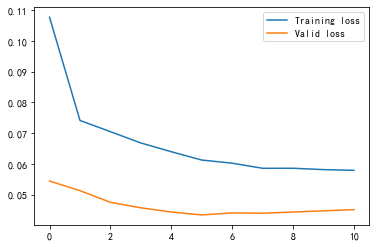

In [6]:
plt.plot(train_hist, label="Training loss")
plt.plot(valid_hist, label="Valid loss")
plt.legend()

In [7]:
checkpoints=torch.load(args.model_name,map_location=args.device)
model.load_state_dict(checkpoints['model_state_dict'])
model.eval()
with torch.no_grad():
    preds_test = []
    trues_test = []
    for test_data, test_labels in test_dataloader:
        y_test_pred = model(test_data.to(args.device))
        preds_test += y_test_pred.cpu().numpy().flatten().tolist()
        trues_test += test_labels.cpu().numpy().flatten().tolist()

    preds_valid = []
    trues_valid = []
    for valid_data, valid_labels in valid_dataloader:
        y_valid_pred = model(valid_data.to(args.device))
        preds_valid += y_valid_pred.cpu().numpy().flatten().tolist()
        trues_valid += valid_labels.cpu().numpy().flatten().tolist()

    preds_all = []
    trues_all = []
    for all_data, all_labels in all_dataloader:
        y_all_pred = model(all_data.to(args.device))
        preds_all += y_all_pred.cpu().numpy().flatten().tolist()
        trues_all += all_labels.flatten().tolist()

true_cases = test_dataset.inverse_transform(np.expand_dims(trues_test, axis=0)).flatten()
predicted_cases = test_dataset.inverse_transform(np.expand_dims(preds_test, axis=0)).flatten()

true_cases_valid = valid_dataset.inverse_transform(np.expand_dims(trues_valid, axis=0)).flatten()
predicted_cases_valid = valid_dataset.inverse_transform(np.expand_dims(preds_valid, axis=0)).flatten()

true_cases_all = all_dataset.inverse_transform(np.expand_dims(trues_all, axis=0)).flatten()
predicted_cases_all = all_dataset.inverse_transform(np.expand_dims(preds_all, axis=0)).flatten()

print(f'all: mse={mean_squared_error(true_cases_all,predicted_cases_all)} mae={mean_absolute_error(true_cases_all,predicted_cases_all)}')
print(f'valid: mse={mean_squared_error(true_cases_valid,predicted_cases_valid)} mae={mean_absolute_error(true_cases_valid,predicted_cases_valid)}')
print(f'test: mse={mean_squared_error(true_cases,predicted_cases)} mae={mean_absolute_error(true_cases,predicted_cases)}')

# electricity
# all: mse=23384.94238751957 mae=105.44099901267673
# valid: mse=13212.816792113163 mae=73.22982830035205
# test: mse=9473.049733526954 mae=73.9542327025651

# traffic
# all: mse=2.856526621967952e-05 mae=0.0036769676847540618
# valid: mse=6.5846232448871e-05 mae=0.003775134115138555
# test: mse=1.0808857353610751e-05 mae=0.0025510864636332665

# ETTh1
# all: mse=5.496895970359073 mae=1.1646477654965406
# valid: mse=0.4108859489733887 mae=0.4074636246344653
# test: mse=0.31827892742466457 mae=0.3749101886642868

# exchange_rate
# all: mse=9.454308719863539e-05 mae=0.006376903486050394
# valid: mse=3.1882977949612184e-05 mae=0.00368439049986266
# test: mse=2.8713712617290014e-05 mae=0.003483359251143044

# weather
# all: mse=6.70560754018422 mae=1.3167095845029118
# valid: mse=1.319019602691708 mae=0.8208617173492188
# test: mse=1.7324234840993675 mae=0.8381547336254703

# daily_min_temperatures
# all: mse=5.841430415198538 mae=1.8973894142387386
# valid: mse=5.663222648173579 mae=1.8673052131869985
# test: mse=4.279558615604504 mae=1.5494373785626525

all: mse=23384.94238751957 mae=105.44099901267673
valid: mse=13212.816792113163 mae=73.22982830035205
test: mse=9473.049733526954 mae=73.9542327025651


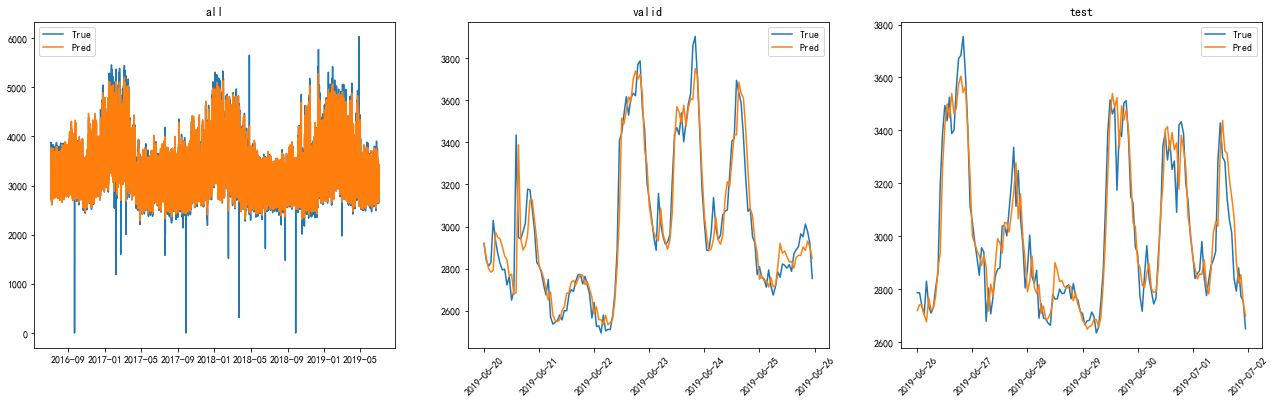

In [8]:
fig,ax=plt.subplots(1,3,figsize=(22,6))
ax[0].plot(data.index[args.seq_len:],true_cases_all,label='True')
ax[0].plot(data.index[args.seq_len:],predicted_cases_all,label='Pred')
ax[0].set_title('all')
ax[0].legend()
ax[1].plot(valid.index,true_cases_valid,label='True')
ax[1].plot(valid.index,predicted_cases_valid,label='Pred')
ax[1].set_title('valid')
ax[1].legend()
ax[1].tick_params(axis='x', labelrotation=45)
ax[2].plot(test.index,true_cases,label='True')
ax[2].plot(test.index,predicted_cases,label='Pred')
ax[2].set_title('test')
ax[2].legend()
ax[2].tick_params(axis='x', labelrotation=45)
plt.show()

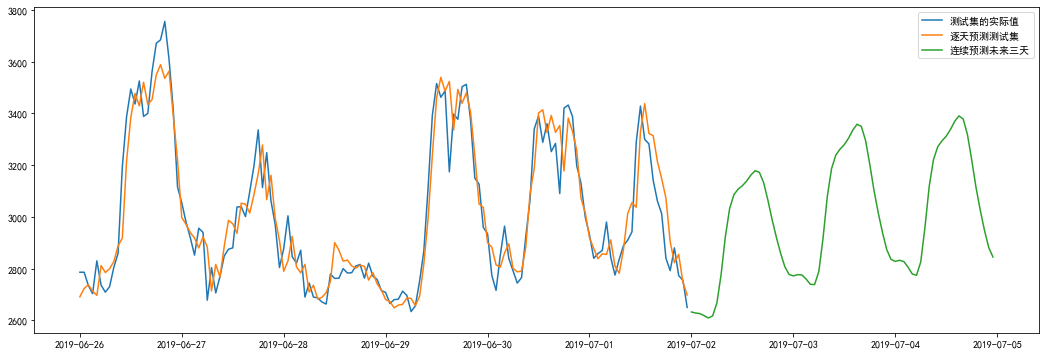

In [9]:
# 根据验证集按天迭代预测测试集
DAYS_TO_PREDICT = len(test)
model.eval()
with torch.no_grad():
    test_seq = torch.from_numpy(all_dataset.data[-(args.seq_len+len(test)):-len(test)]).view(1, args.seq_len, 1).float()
    preds = []
    for i in range(DAYS_TO_PREDICT):
        y_pred = model(test_seq.to(args.device))
        pred = y_pred.item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten().tolist()
        new_seq.append(all_dataset.scaler.transform(np.array([test.iloc[i]]).reshape(-1, 1)).item())
        new_seq = new_seq[1:]
        test_seq = torch.from_numpy(np.array(new_seq)).view(1, args.seq_len, 1).float()

preds = all_dataset.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
forcast_df1=pd.Series(preds,name=args.label)
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    forcast_df1.index=pd.date_range(start=valid.index.max()+datetime.timedelta(hours=1),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path == 'weather.csv':
    forcast_df1.index=pd.date_range(start=valid.index.max()+datetime.timedelta(minutes=10),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    forcast_df1.index=[i.date() for i in pd.date_range(start=valid.index.max()+datetime.timedelta(days=1),periods=DAYS_TO_PREDICT)]
forcast_df1.index.name=args.date_col

# 根据测试集按天迭代预测接下来的时间
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    DAYS_TO_PREDICT = 3 * 24
    label='连续预测未来三天'
elif args.path == 'weather.csv':
    DAYS_TO_PREDICT = 1 * 6 * 24
    label='连续预测未来一天'
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    DAYS_TO_PREDICT = 31
    label='连续预测未来一个月'
model.eval()
with torch.no_grad():
    test_seq = torch.from_numpy(all_dataset.data[-args.seq_len:]).view(1, args.seq_len, 1).float()
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_pred = model(test_seq.to(args.device))
        pred = y_pred.item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten().tolist()
        new_seq.append(pred)
        new_seq = new_seq[1:]
        test_seq = torch.from_numpy(np.array(new_seq)).view(1, args.seq_len, 1).float()

preds = all_dataset.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
forcast_df2=pd.Series(preds,name=args.label)
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    forcast_df2.index=pd.date_range(start=data.index.max()+datetime.timedelta(hours=1),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path == 'weather.csv':
    forcast_df2.index=pd.date_range(start=data.index.max()+datetime.timedelta(minutes=10),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    forcast_df2.index=pd.date_range(start=data.index.max()+datetime.timedelta(days=1),periods=DAYS_TO_PREDICT)
forcast_df2.index.name=args.date_col

fig,ax=plt.subplots(1,1,figsize=(18,6))
ax.plot(test.index,test.values,label='测试集的实际值')
ax.plot(test.index,forcast_df1.values,label='逐天预测测试集')
ax.plot(forcast_df2.index,forcast_df2.values,label=label)
ax.legend()
plt.show()